# Section 4. Basics of Google Earth Engine Python Integration

#### Instructor: Pierre Biscaye 

The objective of this notebook is to introduce you to how to use Google Earth Engine (GEE) tools within Python.

### Learning Objectives
1. Authenticating your account
2. Basic calls with the the ee integration package
3. Using the geemap package to visualize data
4. Intro to visualizing satellite imagery data

### Libraries loaded
* ee
* geemap
* pandas
* scipy
* numpy
* matplotlib

# 1. Authenticate your EE account

Note that the first time we use `ee` on a given computer, we will need to **authenticate**. Visit the [Python setup guide](https://developers.google.com/earth-engine/guides/python_install) for some useful information. 

We will use the `ee.Authenticate()` function to do this. To streamline it, we will set `auth_mode='localhost'` so that everything happens in the browser and you don't have to copy in an authorization token/code.

You will be prompted to allow access to parts of your Google account. This is just so Google can go to the right places to authenticate you. You should agree to this, and then follow all prompts until you see a success window.

You will then need to initialize your project. This is because of GEE's usage limits - it needs to tie your python integration to a specific Google Cloud project so that it knows how to deal with your requests.

Go to the [Google Cloud Console](https://console.cloud.google.com/) to get your Project ID.

In [1]:
import ee

In [14]:
ee.Authenticate(force=True, auth_mode='localhost')


Successfully saved authorization token.


In [2]:
ee.Initialize(project="ee-pbiscaye")

Though you won't need to authenticate every time, you will need to initialize your project every time.

If you only have one project and want to set the project ID permanently, you can run `earthengine set_project your-project-id` in your terminal directly (not in Jupyter Notebook).

Let's test that everything is working!

In [3]:
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


And now a test data call: getting the metadata of a standard global dataset (SRTM Elevation).

In [17]:
dem = ee.Image('USGS/SRTMGL1_003')
print(dem.get('title').getInfo())

NASA SRTM Digital Elevation 30m


# 2. Practice using the integration

We'll follow an example application of the Python GEE integration following some [example code](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api) from the Google GEE Developers platform.

First, we’ll see how to get the timeseries of a variable for a region of interest. An application of this procedure will be done to extract land surface temperature in an urban and a rural area near the city of Lyon, France to illustrate the heat island effect. The example code on the developers platform also details procedures for static mapping and exporting results as a GeoTIFF, and for using the folium library to make interactive maps.

## Importing data

We'll start by importing some data from the Earth Engine Catalog. Catalog datasets can be of different types:
* **Features** which are geometric objects with a list of properties. For example, a watershed with some properties such as name and area, is an ee.Feature.
* **Images** which are like features, but may include several bands. For example, the ground elevation given by the USGS is an ee.Image.
* **Collections** which are groups of features or images. For example, the Global Administrative Unit Layers giving administrative boundaries is a `ee.FeatureCollection` and the MODIS Land Surface Temperature dataset is an `ee.ImageCollection`.

In the following sections, we work with the [MODIS land cover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1) (LC; note: deprecated), [MODIS land surface temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) (LST) and [USGS ground elevation](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) (ELV). 

The **dataset descriptions** provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated with images in the collection. They also include important information on the resolution, frequency, and spatial and temporal extent of the data. We should always read the description carefully and make sure you know the key features of the dataset we are importing. 

As you can see in the description of the datasets, they include several sets of information stored in several **bands**. For example, these bands are associated with the LST collection:
* LST_Day_1km: Daytime Land Surface Temperature
* Day_view_time: Local time of day observation
* LST_Night_1km: Nighttime Land Surface Temperature
* etc.

The description page of the collection tells us that the name of the band associated with the daytime LST is LST_Day_1km which is in units of Kelvin. In addition, values are ranging from 7,500 to 65,535 with a corrective scale of 0.02.

While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection. 

In [8]:
# Import the MODIS land cover collection.
# yearly images at a 500 m resolution
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
# daily images in a 1 km resolution
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
# a single image representing data for the year 2000 in a 30 m resolution
elv = ee.Image('USGS/SRTMGL1_003')

## Preparing data

Then, we have to **filter** the collection on the period of time we want. We can do that using the filterDate() method. 

To **select the bands**, you need to know what they are. We can look at the first image in that collection, as all images in a standard collection share the same band structure. We use `first()` to get the first image, `bandNames()` to identify the bands, and `getInfo()` to return the values.

We decide to focus on daytime LST so we select the daytime band LST_Day_1km and its associated quality indicator QC_Day with the `select()` method.


In [9]:
# Get the first image from the collection
lst_first = lst.first()

# Extract and print the band names
band_names = lst_first.bandNames().getInfo()
print("Available Bands:", band_names)

Available Bands: ['LST_Day_1km', 'QC_Day', 'Day_view_time', 'Day_view_angle', 'LST_Night_1km', 'QC_Night', 'Night_view_time', 'Night_view_angle', 'Emis_31', 'Emis_32', 'Clear_day_cov', 'Clear_night_cov']


In [5]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want to know more about LC, LST and ELV. For this example, let's use two point locations:
* The first one in the urban area of Lyon, France
* The second one, 30 kilometers away from the city center, in a rural area

In [6]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using the following methods (to get more information about available methods and required arguments, please visit the API documentation [here](https://developers.google.com/earth-engine/api_docs)):
* sample(): samples the image (does NOT work for an `ee.ImageCollection` — we'll talk about sampling an ee.ImageCollection later) according to a given geometry and a scale (in meters) of the projection to sample in. It returns an `ee.FeatureCollection`.
* first(): returns the first entry of the collection,
* get(): to select the appropriate band of your Image/Collection,
* getInfo(): evaluates server-side expression graph and transfers result to client.

Then we can query the ground elevation and LST around our point of interest. 

Note that we need to be careful when evaluating LST. According to the dataset description, the value should be corrected by a factor of 0.02 to get units of Kelvin (do not forget the conversion). To get the mean multi-annual daytime LST, we use the mean() collection reduction method on the LST `ee.ImageCollection`. (The following run might take about 15-20 seconds)

In [10]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 196 m
Average daytime LST at urban point: 22.11 °C
Land cover value at urban point is: 13


Going back to the band description of the `lc` dataset, we see that a lc value of "13" corresponds to urban land.

## Getting a time series

We showed above how to get geospatial information about a given point of interest. We'll import a time series of land surface temperature for the two targeted locations using the `getRegion()` method. We will still rescale to 1 km pixels, as above. Remember that `getInfo()` at the end is what actually calls the targeted information.

In [11]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id',
  'longitude',
  'latitude',
  'time',
  'LST_Day_1km',
  'QC_Day',
  'Day_view_time',
  'Day_view_angle',
  'LST_Night_1km',
  'QC_Night',
  'Night_view_time',
  'Night_view_angle',
  'Emis_31',
  'Emis_32',
  'Clear_day_cov',
  'Clear_night_cov'],
 ['2000_02_24',
  4.810478346460038,
  45.77365530231022,
  951350400000,
  None,
  2,
  None,
  None,
  None,
  2,
  None,
  None,
  None,
  None,
  None,
  None],
 ['2000_02_25',
  4.810478346460038,
  45.77365530231022,
  951436800000,
  None,
  2,
  None,
  None,
  13596,
  81,
  224,
  84,
  240,
  243,
  None,
  1059],
 ['2000_02_26',
  4.810478346460038,
  45.77365530231022,
  951523200000,
  14365,
  145,
  120,
  115,
  13990,
  81,
  215,
  10,
  240,
  243,
  2000,
  4000],
 ['2000_02_27',
  4.810478346460038,
  45.77365530231022,
  951609600000,
  14391,
  81,
  110,
  38,
  14081,
  81,
  222,
  64,
  240,
  243,
  1967,
  2000]]

You may notice many `None` values for `LST_Day_1km`. Looking at the `QC_day` values, these take a value of 2 which means that the LST is not calculated due to cloud effects.

Now let's transform this to a pandas dataframe to make it easier to work with. We'll also convert the Kelvin degree units to degrees Celsius.

In [13]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data on LST.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

In [14]:
# Apply the functions to the urban point
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
2,951523200000,2000-02-26,14.15
3,951609600000,2000-02-27,14.67
4,951696000000,2000-02-28,16.17
9,952128000000,2000-03-04,7.11
10,952214400000,2000-03-05,12.49


Now let's plot the time series. To map the seasonality of temperature in France, we will fit the following sinusoidal function (Stallman, 1965):

$LST(t) = LST_0 + \frac{\Delta LST}{2}\sin(\frac{2\pi t}{\tau} + \phi) $

In this function, we have:
* Mean annual LST, $LST_0$
* Range of LST, $\Delta LST$
* Period of oscillation of LST $\tau$
* Offset to adjust time when $LST(t)=LST_0$, $\phi$.

We will plot this using the scipy library.

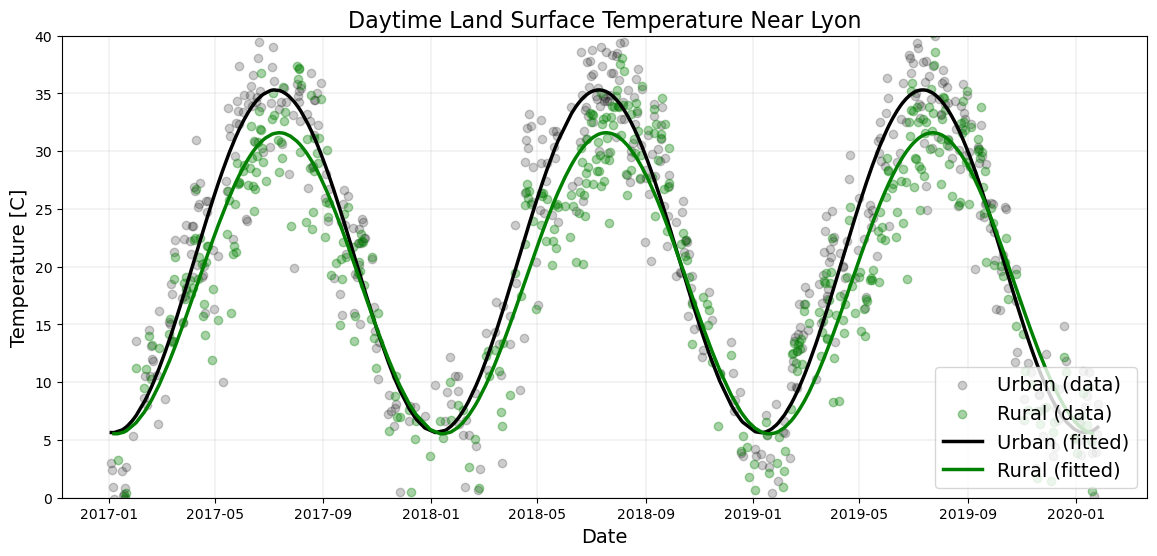

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Focus on 2017-2019
start_date = "2017-01-01"
end_date = "2020-01-31"

mask = (lst_df_urban['datetime'] >= start_date) & (lst_df_urban['datetime'] <= end_date)
lst_df_urban_filt = lst_df_urban.loc[mask]
mask = (lst_df_rural['datetime'] >= start_date) & (lst_df_rural['datetime'] <= end_date)
lst_df_rural_filt = lst_df_rural.loc[mask]

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban_filt['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural_filt['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban_filt['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural_filt['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban_filt['datetime'], lst_df_urban_filt['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural_filt['datetime'], lst_df_rural_filt['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban_filt['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural_filt['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

# 3. Working with GEEMAP

The `geemap` library is used for displaying map tiles and printing rich representations of Earth Engine objects. The library depends respectively on ipyleaflet and eerepr for these features. The geemap library and its dependencies are preinstalled in Google Colab; import it into each session.

In [18]:
import geemap

In [20]:
# Initialize a map object
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

## Adding an elevation layer

Let's layer on something useful!

We will load the SRTM (Shuttle Radar Topography Mission) dataset. It provides elevation data for nearly the entire globe at 30-meter resolution. It's a useful starting dataset because it's a single `ee.Image` (static) rather than an `ee.ImageCollection` (which requires filtering by date).

In [21]:
# Load a Digital Elevation Model (SRTM)
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters (min/max elevation in meters)
vis_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

# Add the layer and center the map on Clermont-Ferrand
m.addLayer(dem, vis_params, 'SRTM DEM')
m.setCenter(3.081, 45.777, 8) # Longitude, Latitude, Zoom

m

Map(bottom=812.0, center=[45.777, 3.081], controls=(WidgetControl(options=['position', 'transparent_bg'], posi…

## Working with satellite imagery

Let's try to a cloud-free view of the area around Clermont-Ferrand. We will use the Sentinel-2 satellite imagery collection.

Sentinel-2 is perfect for this because it has a high revisit frequency. This is important because we will need to **filter out cloudy days**. A high revisit rate gives us many "chances" to find a day where the Puy de Dôme isn't hidden by clouds.

The below code will pull the images, filter them by your location and dates, and then use the "Median" reducer to create a composite image that masks out any stray clouds.

What does the **Median Reducer** do? Instead of looking for one "perfect" image (which might not exist in a cloudy region), the `.median()` function acts like a "ghost remover." Since clouds are bright and move, taking the median value for a pixel across 20 images usually leaves you with the dark, stable ground.

In [22]:
# 1. Initialize the map and center on your coordinates
Map = geemap.Map()
clermont_point = ee.Geometry.Point([3.081, 45.777])
Map.centerObject(clermont_point, 12)

# 2. Load the Sentinel-2 Surface Reflectance collection
# We'll look at the last 6 months of 2025/early 2026
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(clermont_point)
                 .filterDate('2025-08-25', '2026-01-25')
                 # Pre-filter to only images with less than 20% cloud cover
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# 3. Create a Median Composite
# This looks at every pixel over those months and picks the median value,
# which effectively removes temporary clouds or shadows.
cloud_free_image = s2_collection.median()

# 4. Set Visualization Parameters (True Color: Red, Green, Blue)
# Sentinel-2 bands for RGB are B4, B3, and B2
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# 5. Add to Map
Map.addLayer(cloud_free_image, vis_params, 'Clermont-Ferrand Cloud-Free')
Map

Map(center=[45.777000000000015, 3.0810000000000004], controls=(WidgetControl(options=['position', 'transparent…

The Sentinel-2 data are **multispectral** (we will cover this next week). Above we selected specific bands of visible light: B4, B3, and B2. Other bands are useful for different purposes. 

For example, if we wanted to see the health of the vegetation, we could switch to B8 (Near-Infrared), which makes healthy plants appear bright red. Let's now calculate the NDVI (Normalized Difference Vegetation Index), a classic remote sensing index. It’s a simple calculation that compares the Red and Near-Infrared (NIR) bands to measure "greenness." Healthy plants absorb Red light but reflect NIR like a mirror.

In [23]:
# 1. Calculate NDVI
# Formula: (NIR - Red) / (NIR + Red) 
# For Sentinel-2: (B8 - B4) / (B8 + B4)
ndvi = cloud_free_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# 2. Set Visualization for NDVI
# NDVI values range from -1.0 to 1.0. 
# 0.2 to 0.8 is usually where vegetation lives.
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['#FFFFFF', '#CE7E45', '#DF923D', '#F1B555', '#FCD163', 
                '#99B718', '#74A901', '#66A000', '#529400', '#3E8601', 
                '#207401', '#056201', '#004C00', '#023B01', '#012E01', 
                '#011D01', '#011301']
}

# 3. Add the layers to the map
Map.addLayer(ndvi, ndvi_vis, 'Vegetation Health (NDVI)')

# Add a color bar to help interpret the colors
Map.add_colorbar(ndvi_vis, label="NDVI (Greenness)")

Map

Map(bottom=374276.0, center=[45.777000000000015, 3.0810000000000004], controls=(WidgetControl(options=['positi…

### Exporting data

What if we want to **export** this? 

The image covers a large space (zoom out!) So we need to define a region of interest (ROI).

We can then use `ee_export_image()`. We will export this as a `tif`, a common format for spatial data that retains coordinate data so it can be merged later with other spatial data. 

We should pay careful attention to **scale parameter**. This is the most important setting. Since Sentinel-2 has a native resolution of 10 meters, setting `scale=10` ensures we get the highest quality. But this could be a large file to process and download so we will set to 100 for a faster download and smaller file. 

*Note*: If the ROI is too large (e.g., the whole of France) and the scale is too small (10m), the export will fail because it exceeds the Google Earth Engine "User Memory" limit.

When we execute, we will see the code indicating that we are downloading data from Earth Engine using its API.

In [27]:
# 1. Define the clipping zone (ROI)
# We'll create a 10km buffer around our Clermont-Ferrand point
roi = clermont_point.buffer(10000).bounds()

# 2. Export the NDVI image
# Note: 'scale' is the resolution in meters. Sentinel-2 is 10m.
geemap.ee_export_image(
    ndvi, 
    filename='Data/clermont_ndvi.tif', 
    scale=100, 
    region=roi, 
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /Users/pierrebiscaye/Dropbox/Class-DataScience/Section 4/Data/clermont_ndvi.tif
